# Per-capita CBA of Animal-based Emissions (2020–2022)

This notebook computes **per-capita, consumption-based emissions (CBA)** for
**animal-based foods** using **EXIOBASE 3.9 (2020–2022)** and **World Bank
population data**, and produces a 3-year comparison figure (2020, 2021, 2022).

Key choices:

- We keep only **animal sectors** (cattle, pigs, poultry, dairy, fish, etc.).
- We include **all non-LUC emissions** captured by EXIOBASE:
  - enteric, manure, soils/fertilizers, energy, upstream supply-chain, etc.
- We group countries into:
  - **GN** – Global North
  - **CN** – China
  - **GS** – Global South (ex-China)
- We use **World Bank population** (2020–2022) and manually add **Taiwan, China**,
  because it is not provided separately in the WB dataset. Values are from
  Taiwan’s National Statistics (via Demographics of Taiwan, accessed 2025).

In [2]:
from __future__ import annotations

# --- Standard library imports ---
import io, zipfile, csv, glob, warnings
from pathlib import Path
from typing import List, Optional, Tuple

# --- Scientific stack ---
import numpy as np
import pandas as pd

# --- Plotting ---
import matplotlib.pyplot as plt
import matplotlib as mpl

## 0) Paths and plotting style

- Inputs are expected under `./data/`
- Outputs (CSVs + figures) are written to `./outputs/`

In [3]:
DATA_DIR = Path("data")
OUT_DIR  = Path("outputs")
OUT_DIR.mkdir(exist_ok=True)


mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "pdf.fonttype": 42, "ps.fonttype": 42,
    "figure.dpi": 300,
    "figure.figsize": (10, 6),
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "axes.titlepad": 10,
    "axes.grid": True,
    "grid.linestyle": "--", "grid.alpha": 0.30,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "legend.frameon": False,
    "lines.linewidth": 2.0,
})

## 1) Region groups and EXIOBASE → World Bank mapping

- EXIOBASE regions use **ISO2**-like codes (AT, BE, CN, BR, etc.)
- World Bank population uses **country names** (“Austria”, “China”, “Brazil”, …)

We:
1. Define which EXIO regions belong to **Global North (GN)**.
2. Map EXIO ISO2 codes → World Bank *Country Name* strings.
3. Use `which_group()` to assign each EXIO region to GN / CN / GS.

Note: aggregated EXIO “Rest of World” regions such as WA, WE, WF, WL, WM do not
have direct WB population matches. We **exclude** them from per-capita
calculations (they remain a small share of global emissions and population).

In [4]:
# Countries counted in Global North (GN) for reporting
GN_ISO2 = {
    "AT","BE","BG","CY","CZ","DE","DK","EE","ES","FI","FR","GR","HR","HU","IE","IT",
    "LT","LU","LV","MT","NL","PL","PT","RO","SE","SI","SK","GB","NO","CH","IS",
    "US","CA","AU","NZ","JP","KR","TW"
}

def which_group(iso2: str) -> str:
    """
    Return GN / CN / GS for a given EXIO ISO2 region code.
      - 'CN'  → China
      - GN_ISO2 → Global North
      - else   → Global South
    """
    if iso2 == "CN":
        return "CN"
    return "GN" if iso2 in GN_ISO2 else "GS"

# Map EXIO ISO2 codes to World Bank 'Country Name' strings
# NOTE: Turkey is mapped to 'Türkiye' to match updated WB naming.
MAP_EXIO_TO_WB = {
    "AT":"Austria","BE":"Belgium","BG":"Bulgaria","CY":"Cyprus","CZ":"Czechia","DE":"Germany","DK":"Denmark",
    "EE":"Estonia","ES":"Spain","FI":"Finland","FR":"France","GR":"Greece","HR":"Croatia","HU":"Hungary",
    "IE":"Ireland","IT":"Italy","LT":"Lithuania","LU":"Luxembourg","LV":"Latvia","MT":"Malta","NL":"Netherlands",
    "PL":"Poland","PT":"Portugal","RO":"Romania","SE":"Sweden","SI":"Slovenia","SK":"Slovak Republic",
    "GB":"United Kingdom","NO":"Norway","CH":"Switzerland","IS":"Iceland","US":"United States","CA":"Canada",
    "AU":"Australia","NZ":"New Zealand","JP":"Japan","KR":"Korea, Rep.","TW":"Taiwan, China",
    "BR":"Brazil","IN":"India","MX":"Mexico","RU":"Russian Federation","TR":"Türkiye","ID":"Indonesia",
    "ZA":"South Africa","CN":"China"
}

## 2) Animal-based sectors

We only want emissions from **animal-based foods** in each consumer’s basket.
We therefore keep only EXIOBASE sectors whose name contains an animal keyword.

In [5]:
ANIMAL_KEYWORDS = [
    "Cattle farming","Pigs farming","Poultry farming","Meat animals",
    "Raw milk","Animal products","Processing of meat","Production of meat products",
    "Processing of dairy","Manufacture of fish products","Fishing"
]

## 3) Small helpers

- `_sniff_delim()` guesses CSV delimiters.
- `find_wb_pop_file()` finds the World Bank population file in `./data/`.

In [6]:
def _sniff_delim(sample_text: str, fallback: str = ",") -> str:
    """Guess whether a text file is tab-, comma-, or semicolon-separated."""
    try:
        return csv.Sniffer().sniff(sample_text).delimiter
    except Exception:
        if sample_text.count("\t") >= sample_text.count(","):
            return "\t"
        return fallback

def find_wb_pop_file(data_dir: Path = Path("data")) -> Path:
    """
    Find the World Bank population file in ./data/.
    We first look for the original ZIP; if not found, we look for CSV.
    """
    # Try zips first
    for pat in ["API_SP.POP.TOTL_DS2_*.zip", "API_SP.POP.TOTL_*.zip", "*POP*TOTL*.zip"]:
        hits = sorted(Path(p) for p in glob.glob(str(data_dir / pat)))
        if hits:
            return hits[-1]
    # Fallback: CSV directly in data/
    for pat in ["API_SP.POP.TOTL_DS2_*.csv", "API_SP.POP.TOTL_*.csv", "*POP*TOTL*.csv"]:
        hits = sorted(Path(p) for p in glob.glob(str(data_dir / pat)))
        if hits:
            return hits[-1]
    raise FileNotFoundError("World Bank population file not found in ./data/")

## 4) Load EXIOBASE matrices: A, Y, x, F

- **A**: input coefficients (who buys what from whom per 1 EUR of output)
- **Y**: final demand (what households/government buy)
- **x**: total output by industry (EUR/year)
- **F**: emissions per industry (kg/year of pollutants)

We align **F** columns to be in the same order as **A.columns** so we can
compute **emissions per euro** correctly.

In [7]:
def _find_member(names, patterns):
    """Find the first zip member whose name contains all pattern substrings."""
    pats = [p.lower() for p in patterns]
    for n in names:
        s = n.lower()
        if all(p in s for p in pats):
            return n
    return None

def load_exio(exio_zip: Path):
    """
    Read A, Y, x, and F from an EXIOBASE ixi zip.
    Returns:
      - A: (supplier_region, supplier_sector) x (buyer_region, buyer_sector)
      - Y: (origin_region, origin_sector) x (dest_region, category)
      - x_df: DataFrame [region, sector, indout]
      - F: emissions table [pollutant x (region, sector)]
    """
    with zipfile.ZipFile(exio_zip, "r") as z:
        names = z.namelist()

        # Locate key files inside the zip
        A_name = _find_member(names, ["a.txt"])
        Y_name = _find_member(names, ["y.txt"])
        x_name = _find_member(names, ["x.txt"]) or _find_member(names, ["indout"])
        assert A_name and Y_name and x_name, "Missing A/Y/x in EXIO zip."

        # A and Y: multi-index
        A = pd.read_csv(z.open(A_name), sep="\t", header=[0,1], index_col=[0,1], low_memory=False)
        Y = pd.read_csv(z.open(Y_name), sep="\t", header=[0,1], index_col=[0,1], low_memory=False)
        A.index.names   = ["supplier_region","supplier_sector"]
        A.columns.names = ["buyer_region","buyer_sector"]
        Y.index.names   = ["origin_region","origin_sector"]
        Y.columns.names = ["dest_region","category"]

        # x (total output)
        raw_x = z.read(x_name).decode("utf-8", errors="ignore")
        delim = _sniff_delim("\n".join(raw_x.splitlines()[:5]))
        x_df = pd.read_csv(io.StringIO(raw_x), sep=delim, low_memory=False)

        # Normalize column names
        ren = {}
        for c in x_df.columns:
            lc = c.lower().strip()
            if lc in ("region","country","area"):
                ren[c] = "region"
            elif lc in ("sector","industry","product"):
                ren[c] = "sector"
            elif lc.startswith("indout") or lc in ("output","total output","x"):
                ren[c] = "indout"
        x_df = x_df.rename(columns=ren)
        if not {"region","sector","indout"}.issubset(x_df.columns):
            raise ValueError(f"x columns not recognized: {x_df.columns.tolist()}")
        x_df = x_df[["region","sector","indout"]]

        # F: emissions table (choose the widest air/emissions file)
        candidates = [
            n for n in names
            if ("air" in n.lower() or "emiss" in n.lower())
            and n.lower().endswith(".txt")
            and "unit" not in n.lower()
        ]
        if not candidates:
            raise FileNotFoundError("No air/emissions .txt found in EXIO zip.")
        best = None
        for n in candidates:
            raw = z.read(n).decode("utf-8", errors="ignore")
            line = next((l for l in raw.splitlines() if l.strip()), "")
            delimF = "\t" if line.count("\t") >= max(line.count(","), line.count(";")) \
                     else ("," if line.count(",") >= line.count(";") else ";")
            cols = line.count(delimF) + 1
            if best is None or cols > best[0]:
                best = (cols, delimF, n, raw)
        _, delimF, F_name, raw_F = best
        F_raw = pd.read_csv(io.StringIO(raw_F), sep=delimF, header=0, low_memory=False)
        F_raw = F_raw.rename(columns={F_raw.columns[0]: "pollutant"}).set_index("pollutant")

    # Align F columns to A columns
    N = len(A.columns)
    assert F_raw.shape[1] >= N, "Emissions table has fewer columns than A."
    F = F_raw.iloc[:, :N].copy()
    F.columns = pd.MultiIndex.from_tuples(list(A.columns))
    F = F.apply(pd.to_numeric, errors="coerce").fillna(0.0)
    return A, Y, x_df, F

## 5) Convert to tCO₂e per euro (emissions intensity)

Steps:

1. Pick **CO₂, CH₄, N₂O** rows from F (kg).
2. Convert to **t CO₂e** using **AR6 GWP100**:
   - CH₄: 27.2
   - N₂O: 273
3. Divide total tCO₂e by industry output **x** (EUR/year) to get:

$$
s_j = \frac{\text{t CO₂e}_j}{x_j} \quad [\text{t CO₂e per EUR}]
$$


where $s_j$ is the emissions factor (t CO$_2$e per EUR) for industry $j$.


In [8]:
def sum_pollutant(F: pd.DataFrame, include_terms: List[str]) -> Optional[pd.Series]:
    """Find and sum rows in F whose names contain all terms (case-insensitive)."""
    inc = [t.lower() for t in include_terms]
    sel = []
    for r in F.index:
        name = str(r).lower()
        if all(t in name for t in inc):
            sel.append(r)
    if not sel:
        return None
    return F.loc[sel].astype(float).sum(axis=0)

def build_co2e_intensity(A: pd.DataFrame, x_df: pd.DataFrame, F: pd.DataFrame) -> pd.Series:
    """
    Return s: emissions intensity (t CO2e per EUR) aligned to A.columns.
    """
    co2 = sum_pollutant(F, ["co2"])
    ch4 = sum_pollutant(F, ["ch4"])
    n2o = sum_pollutant(F, ["n2o"])
    assert co2 is not None and ch4 is not None and n2o is not None, "Missing CO2/CH4/N2O in F."

    # kg → t CO2e using AR6 GWP100
    CO2e_t = (co2 + 27.2 * ch4 + 273.0 * n2o) / 1000.0

    # Align x (EUR/year) to same region/sector order as A.columns
    x_wide = x_df.pivot_table(index="region", columns="sector", values="indout", aggfunc="first")
    x_vec = []
    for rg, sec in zip(A.columns.get_level_values(0), A.columns.get_level_values(1)):
        try:
            x_vec.append(float(x_wide.loc[rg, sec]))
        except Exception:
            x_vec.append(np.nan)
    x_vec = pd.Series(x_vec, index=A.columns, dtype=float)

    # Emissions per euro of output
    s = (CO2e_t / x_vec).replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return s

## 6) Final demand: consumption only, and animal-only rows

- We keep **household + NPISH + government** consumption categories.
- Then we **zero out non-animal sectors** using the `ANIMAL_KEYWORDS` list.

In [9]:
def filter_consumption_Y(Y: pd.DataFrame, include_gov: bool = True) -> pd.DataFrame:
    """
    Sum household/government/NPISH consumption per destination region.
    Returns a table indexed by (origin_region, origin_sector) and one column per
    destination region.
    """
    keep = ["Final consumption expenditure by households"]
    if include_gov:
        keep += [
            "Final consumption expenditure by non-profit organisations serving households",
            "Final consumption expenditure by government",
        ]
    mask = Y.columns.get_level_values("category").isin(keep)
    Y_keep = Y.loc[:, mask]

    # groupby(axis=1, ...) is deprecated → group on transposed
    Y_grouped = Y_keep.T.groupby(level="dest_region").sum().T
    return Y_grouped

def filter_animal_rows(Y_demand: pd.DataFrame) -> pd.DataFrame:
    """
    Zero out rows whose sector name does NOT match our animal keywords.
    This keeps only animal-related purchases in final demand.
    """
    is_animal = Y_demand.index.get_level_values("origin_sector").to_series().apply(
        lambda s: any(k.lower() in str(s).lower() for k in ANIMAL_KEYWORDS)
    )
    Y_animal = Y_demand.copy()
    Y_animal.loc[~is_animal, :] = 0.0
    return Y_animal

## 7) Leontief model: full supply-chain emissions

For each destination region $r$, we:

1. Take its animal-only final demand vector **$\mathbf{y}$** (EUR).

2. Use the **Leontief inverse**:

$$
\mathbf{x}^* = (\mathbf{I} - \mathbf{A})^{-1}\mathbf{y}
$$

where:

- $\mathbf{A}$ is the input–coefficient matrix,  
- $\mathbf{x}^*$ is the total output required in each industry to satisfy that demand  
  (including all direct and indirect supply-chain steps).

3. Multiply by emissions per euro $\mathbf{s}$:

$$
E_r = \sum_j x^*_j \, s_j
$$

This gives total **t CO₂e** triggered globally by animal consumption in region $r$.


In [10]:
def leontief_cba(A: pd.DataFrame, s: pd.Series, Y_animal: pd.DataFrame) -> pd.DataFrame:
    """
    Return a table with total tCO2e caused by animal consumption for each
    destination region (consumption-based).
    """
    A_mat = A.values.astype(float)
    I_minus_A = np.eye(A_mat.shape[0]) - A_mat
    s_vec = s.values.astype(float)

    rows = []
    for dreg in Y_animal.columns:
        # Animal-only final demand for this destination (EUR)
        y = Y_animal[dreg].reindex(A.index).fillna(0.0).values.astype(float)
        if not np.any(y):
            rows.append({"dest_region": dreg, "EF_tCO2e": 0.0})
            continue

        # x* = total output vector required (direct + indirect)
        x_star = np.linalg.solve(I_minus_A, y)

        # Sum over industries: x*_j * s_j  (t CO2e)
        EF_t = float(np.nansum(s_vec * x_star))
        rows.append({"dest_region": dreg, "EF_tCO2e": EF_t})

    return pd.DataFrame(rows)

## 8) Population: 2020–2022 (World Bank + Taiwan manual add)

We:

1. Load the World Bank **total population** dataset (SP.POP.TOTL).
2. Convert to a long format: one row per country & year.
3. **Manually add Taiwan, China** with population values for 2020–2022, because
   the WB dataset does not provide it separately.

Population values for Taiwan are taken from official statistics (via
*Demographics of Taiwan*).

In [11]:
def load_population_all_years(wb_file: Path) -> pd.DataFrame:
    """
    Load World Bank population data for all years.
    Returns a long DataFrame:
      [Country Name, year, population]
    """
    if wb_file.suffix.lower() == ".zip":
        with zipfile.ZipFile(wb_file, "r") as z:
            names = [n for n in z.namelist()
                     if n.endswith(".csv") and "Metadata" not in n]
            if not names:
                raise FileNotFoundError("No main data CSV inside WB zip.")
            raw = z.read(names[0]).decode("utf-8", errors="ignore")
    else:
        raw = wb_file.read_text(encoding="utf-8")

    lines = raw.splitlines()
    # Find header line (containing Country Name + Country Code)
    hdr_idx = next(i for i, l in enumerate(lines[:50])
                   if ("Country Name" in l and "Country Code" in l))
    delim = _sniff_delim("\n".join(lines[hdr_idx:hdr_idx+5]), fallback=",")
    pop_raw = pd.read_csv(
        io.StringIO("\n".join(lines[hdr_idx:])),
        sep=delim,
        dtype=str
    )

    # Keep only numeric year columns
    year_cols = [c for c in pop_raw.columns if c.isdigit()]
    # Melt to long format
    pop_long = pop_raw.melt(
        id_vars=["Country Name"],
        value_vars=year_cols,
        var_name="year",
        value_name="population"
    )
    pop_long["population"] = pd.to_numeric(pop_long["population"], errors="coerce")
    pop_long = pop_long.dropna(subset=["population"])

    # --- Manually add Taiwan, China (not provided by WB) ---
    # Values from official statistics (Demographics of Taiwan; approximate)
    taiwan_pop = {
        2020: 23561000,  # ~23.56 million
        2021: 23359000,  # ~23.36 million
        2022: 23264000,  # ~23.26 million
    }
    # Remove any existing rows for 'Taiwan, China' (they are usually NaN)
    pop_long = pop_long[pop_long["Country Name"] != "Taiwan, China"].copy()
    # Append manual entries
    extra_rows = [{
        "Country Name": "Taiwan, China",
        "year": str(y),
        "population": pop
    } for y, pop in taiwan_pop.items()]
    pop_long = pd.concat([pop_long, pd.DataFrame(extra_rows)], ignore_index=True)

    pop_long["year"] = pop_long["year"].astype(int)
    return pop_long

def map_population_for_year(year: int, pop_long: pd.DataFrame,
                            exio_regions: List[str]) -> pd.DataFrame:
    """
    Map EXIO destination regions → [region, group, population] for a given year.
    Regions without a clear WB mapping are silently skipped (e.g. WA, WE, WF, etc.).
    """
    rows = []
    this_year = pop_long[pop_long["year"] == year]
    for iso2 in exio_regions:
        if iso2 not in MAP_EXIO_TO_WB:
            # WA, WE, WF, WL, WM, etc. are Rest-of-World aggregates: skip
            continue
        wb_name = MAP_EXIO_TO_WB[iso2]
        val = this_year.loc[this_year["Country Name"] == wb_name, "population"]
        if len(val) == 0 or pd.isna(val.values[0]):
            # If still missing, skip this region from per-capita aggregation
            continue
        pop = float(val.values[0])
        rows.append({
            "region": iso2,
            "group": which_group(iso2),
            "population": pop,
            "year": year
        })
    return pd.DataFrame(rows)

## 9) Run the pipeline for multiple years (2020, 2021, 2022)

For each year:

1. Load EXIOBASE `IOT_YEAR_ixi.zip` from `./data/`
2. Build t CO₂e / EUR intensities
3. Keep consumption-only final demand, then animal sectors only
4. Run the Leontief model to get total **t CO₂e** per destination region
5. Map regions to GN / CN / GS and attach populations
6. Aggregate to group totals and per-capita values
7. Save transparent CSVs for:
   - region totals
   - group totals

Finally, we combine the three years into `out_all`.

In [12]:
YEARS = [2020, 2021, 2022]

# Load World Bank population (all years)
wb_file = find_wb_pop_file(DATA_DIR)
pop_long = load_population_all_years(wb_file)

all_rows = []

for year in YEARS:
    print(f"=== Processing {year} ===")

    exio_zip = DATA_DIR / f"IOT_{year}_ixi.zip"
    if not exio_zip.exists():
        raise FileNotFoundError(f"EXIOBASE zip not found: {exio_zip}")

    # Load EXIOBASE matrices
    A, Y, x_df, F = load_exio(exio_zip)

    # Emissions per euro (t CO2e / EUR)
    s = build_co2e_intensity(A, x_df, F)

    # Consumption-only final demand, then restrict to animal sectors
    Y_cons   = filter_consumption_Y(Y, include_gov=True)
    Y_animal = filter_animal_rows(Y_cons)

    # Region-level total emissions (t CO2e) from animal consumption
    EF_dest = leontief_cba(A, s, Y_animal)
    EF_dest["year"] = year

    # Population + grouping for this year
    regions = Y_cons.columns.tolist()  # dest_region ISO2 codes
    pop_map = map_population_for_year(year, pop_long, regions)

    # Restrict to regions we have mapping for
    mapped_regions = set(pop_map["region"])
    EF_mapped = EF_dest[EF_dest["dest_region"].isin(mapped_regions)].copy()
    EF_mapped["group"] = EF_mapped["dest_region"].map(which_group)

    # Save region-level totals per year (transparency)
    EF_mapped.rename(columns={"dest_region": "region",
                              "EF_tCO2e": "total_tCO2e"}).to_csv(
        OUT_DIR / f"region_totals_cba_{year}.csv",
        index=False
    )

    # Group totals and per-capita
    group_totals = (EF_mapped.groupby("group", as_index=False)["EF_tCO2e"]
                    .sum()
                    .rename(columns={"EF_tCO2e": "total_tCO2e"}))

    pop_by_group = (pop_map.groupby("group", as_index=False)["population"]
                    .sum())

    merged = group_totals.merge(pop_by_group, on="group", how="inner")
    merged["per_capita_tCO2e"] = merged["total_tCO2e"] / merged["population"]
    merged["year"] = year

    # Save group totals per year
    merged.to_csv(
        OUT_DIR / f"group_totals_Etotal_{year}_EXIOaligned.csv",
        index=False
    )

    all_rows.append(merged)

# Combine all years into one DataFrame
out_all = pd.concat(all_rows, ignore_index=True)
out_all

=== Processing 2020 ===
=== Processing 2021 ===
=== Processing 2022 ===


,group,total_tCO2e,population,per_capita_tCO2e,year
0,CN,8.694759e+08,1.411100e+09,0.616169,2020
1,GN,8.622142e+08,1.124546e+09,0.766722,2020
2,GS,7.265593e+08,2.218700e+09,0.327471,2020
3,CN,9.439307e+08,1.412360e+09,0.668336,2021
4,GN,8.302598e+08,1.124159e+09,0.738561,2021
5,GS,6.326324e+08,2.234410e+09,0.283132,2021
6,CN,9.597579e+08,1.412175e+09,0.679631,2022
7,GN,8.547477e+08,1.128571e+09,0.757372,2022
8,GS,6.432794e+08,2.249789e+09,0.285929,2022


## 10) Plot: GN / CN / GS per-capita emissions over 2020–2022

We create a grouped bar chart where:

- X-axis: years (2020, 2021, 2022)
- Bars: GN, CN, GS per year

This shows how per-capita animal-based CBA emissions evolve over time.

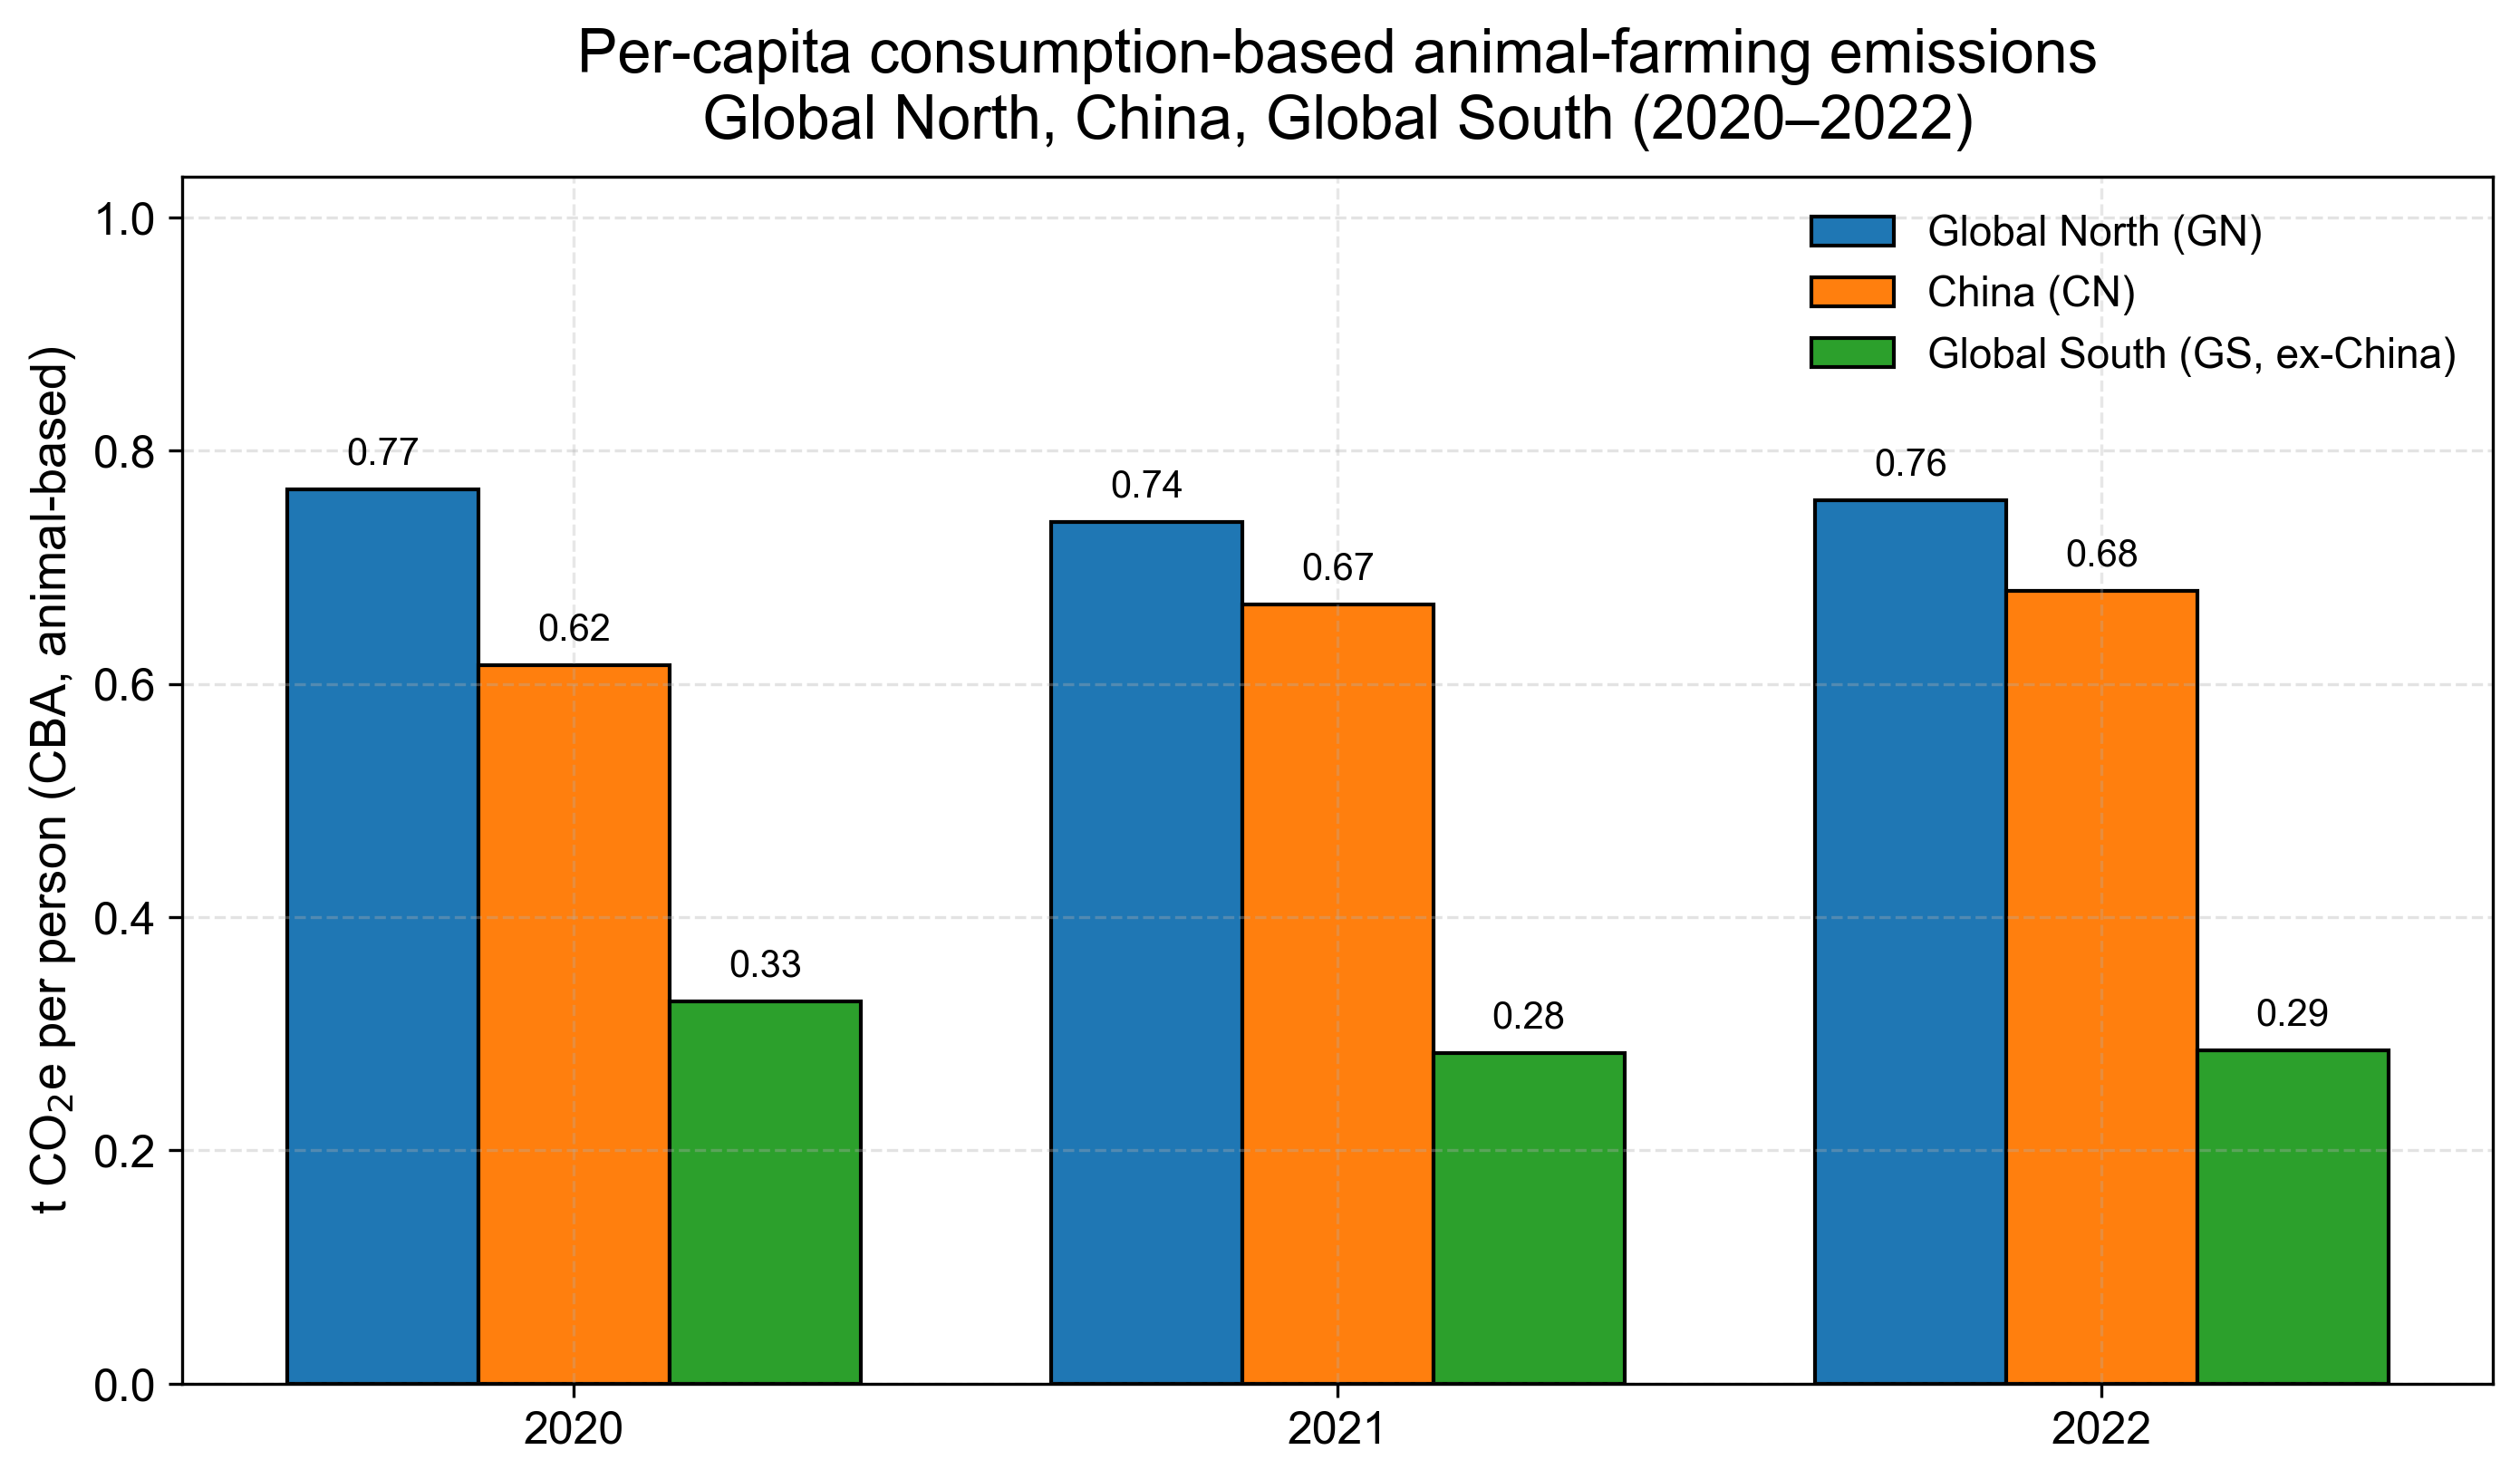

In [13]:
# Ensure groups are in consistent order
groups_order = ["GN", "CN", "GS"]
year_labels   = YEARS

# Build matrix: rows = years, columns = groups
vals = np.zeros((len(YEARS), len(groups_order))) * np.nan
for i, year in enumerate(YEARS):
    df_y = out_all[out_all["year"] == year]
    for j, g in enumerate(groups_order):
        sel = df_y.loc[df_y["group"] == g, "per_capita_tCO2e"]
        vals[i, j] = float(sel.values[0]) if len(sel) > 0 else np.nan

fig, ax = plt.subplots()

x = np.arange(len(YEARS))
bar_width = 0.25

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
labels_pretty = {
    "GN": "Global North (GN)",
    "CN": "China (CN)",
    "GS": "Global South (GS, ex-China)"
}

bars = []
for j, g in enumerate(groups_order):
    offset = (j - 1) * bar_width  # positions: -w, 0, +w
    b = ax.bar(
        x + offset,
        vals[:, j],
        width=bar_width,
        label=labels_pretty[g],
        color=colors[j],
        edgecolor="black"
    )
    bars.append(b)

# X-axis ticks and labels
ax.set_xticks(x)
ax.set_xticklabels([str(y) for y in YEARS])

ax.set_ylabel("t CO$_2$e per person (CBA, animal-based)")
ax.set_title("Per-capita consumption-based animal-farming emissions\nGlobal North, China, Global South (2020–2022)")

# Annotate bars with values
ymax = np.nanmax(vals) if np.isfinite(np.nanmax(vals)) else 0.0
for b in bars:
    for rect in b:
        h = rect.get_height()
        if not np.isnan(h):
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                h + 0.02 * ymax,
                f"{h:.2f}",
                ha="center",
                va="bottom",
                fontsize=10
            )

ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.35)
ax.set_ylim(0, ymax * 1.35 if ymax > 0 else 0.1)
fig.subplots_adjust(top=0.88, bottom=0.14, left=0.12, right=0.97)

# Save figure
pdf_out = OUT_DIR / "percap_animal_CBA_GN_CN_GS_2020_2022.pdf"
png_out = OUT_DIR / "percap_animal_CBA_GN_CN_GS_2020_2022.png"
fig.savefig(pdf_out, bbox_inches="tight")
fig.savefig(png_out, bbox_inches="tight")
plt.show()